### Import useful packages

In [1]:
import os                           # Python's standard OS module for file/folder operations
import numpy as np                  # Python's standard numerical library
import matplotlib.pyplot as plt     # Python's scientific visualization library
from matplotlib.path import Path    # Python's library for path manipulations, helps us omit points outside of structrual boundaries
import pickle as pk                 # Python's library for saving and loading .pkl files, .pkl files are used to save compressed python objects       
from scipy.ndimage import uniform_filter # Python's library for image processing, used for filtering images
from DIC_functions import DIC_Structure         # Importing our custom functions for DIC analysis. DIC_Structure inherets the FeatureSelector class for point selection and the pyIDI class for motion tracking
from pyidi import ROISelect
from sdypy import EMA
import pprint

c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Let's open our video

In [2]:
file_name =  '1mm_meritev_1_nasproti_1_3g_RMS_1s.cih'
file_root = 'D:/thijsmas/HSC - Ladisk/transfer_104353_files_9c630a94'
file_path = os.path.join(file_root, file_name)
DIC_structure = DIC_Structure(file_path)
DIC_structure.video.info #A lot of useful information about the video is saved along with the video:

Available filter methods: eig0, eig1, harris, trigs, harmonic_mean, eig_theta, eig_theta_off, eig0_test, eig1_test


c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\pyMRAW.py:103: UserWarning: Clipped footage! (Total frame: 20000, Original total frame: 102837)
  warnings.warn('Clipped footage! (Total frame: {}, Original total frame: {})'.format(cih['Total Frame'], cih['Original Total Frame'] ))


{'Date': '2018/2/22',
 'Time': '09:41',
 'Camera Type': 'FASTCAM SA-Z type 2100K-M-64GB',
 'Head Type': 'Unknown Child Device',
 'Camera ID': 11,
 'Camera Number': 0,
 'Head Number': 1,
 'Max Head Number': 1,
 'Scene Name': '',
 'User Defined Camera Name': 'Camera No.1',
 'Session Number': '',
 'Date Record': 'Unknown',
 'Time Record': 'Unknown',
 'Trigger Time': 0,
 'Record Rate(fps)': 20000,
 'Shutter Speed(s)': '1/20664',
 'Trigger Mode': 'Start',
 'Original Total Frame': 102837,
 'Total Frame': 20000,
 'Start Frame': 0,
 'Correct Trigger Frame': 0,
 'Save Step': 1,
 'Image Width': 640,
 'Image Height': 696,
 'Color Type': 'Mono',
 'Color Bit': 16,
 'File Format': 'MRaw',
 'EffectiveBit Depth': 12,
 'EffectiveBit Side': 'Higher',
 'Digits Of File Number': 6,
 'Device Last Error': '-1:0xffffffff',
 'Comment Text': '',
 'AnalogBoard Channel Num': 0,
 'Zero Frame': 'Exist',
 'Shutter Type2(nsec)': 48393,
 'Edge Enhance': 0,
 'Pre LUT Mode': 'DEF1',
 'Pre LUT Brightness': 0,
 'Pre LUT C

### Let's plot a frame in our video

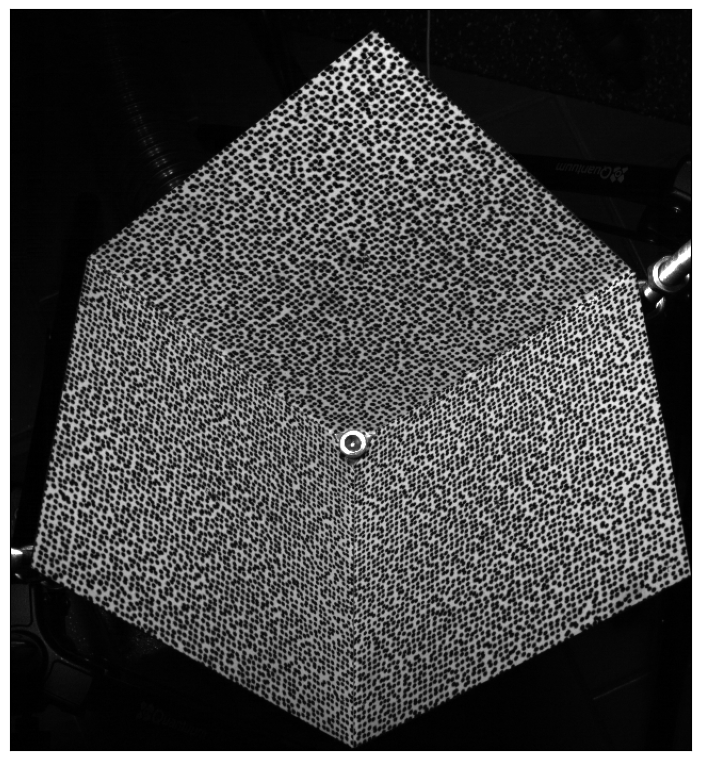

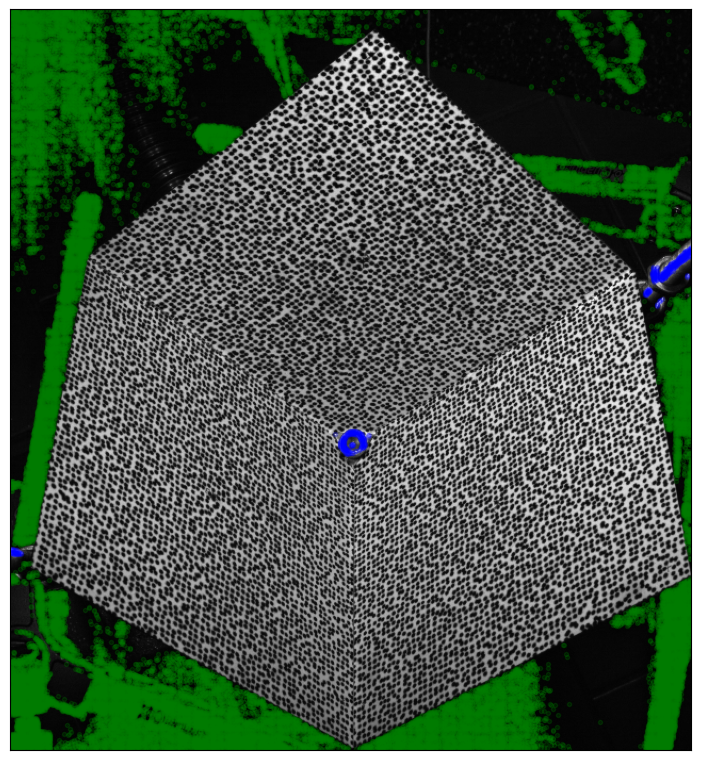

In [3]:
# This line below is used to display plots inline in Jupyter Notebook, replace inline with qt for interactive plots: 
%matplotlib inline

sequential_image_n = 0
still_image = DIC_structure.video.mraw[sequential_image_n]

fig, ax = DIC_structure.plot_frame(sequential_image_n, show_saturation=False, bit_depth = 16)
# fig.savefig(os.path.join(root_drive_sim, 'still images', f'{file_name}_frame_sat0.png'), dpi=300, bbox_inches='tight')
# plt.close(fig)

fig, ax = DIC_structure.plot_frame(sequential_image_n, show_saturation=True, bit_depth = 16)
# fig.savefig(os.path.join(root_drive_sim, 'still images','with saturation', f'{file_name}_frame_sat1.png'), dpi=300, bbox_inches='tight')
# plt.close(fig)

### Now let's play the video

In [4]:
%matplotlib qt
ani = DIC_structure.play_video(frame_range=range(1, DIC_structure.video.N), interval = 30, show_saturation= False, bit_depth = 'auto', ij_counter = (0.3, 0.3))
# Note 1. The animation breaks if you delete 'ani' or not assign it to a variable.
# Note 2. The animation does not work inline in Jupyter Notebook, it only works in a separate window.

### Let's define the boundaries of our structure

In [5]:
# roi_select = ROISelect(DIC_structure.video)
# roi_select.polygon
# polygon = np.array(roi_select.polygon)

polygon = np.array([[235,  26, 247, 529, 692, 523, 235],
       [ 76, 339, 583, 636, 322,  22,  76]])
path = Path(polygon.T)

### Let's make a denoized reference image

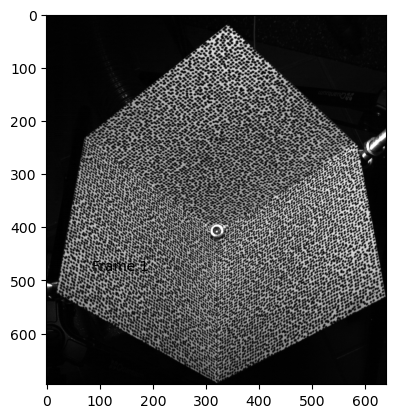

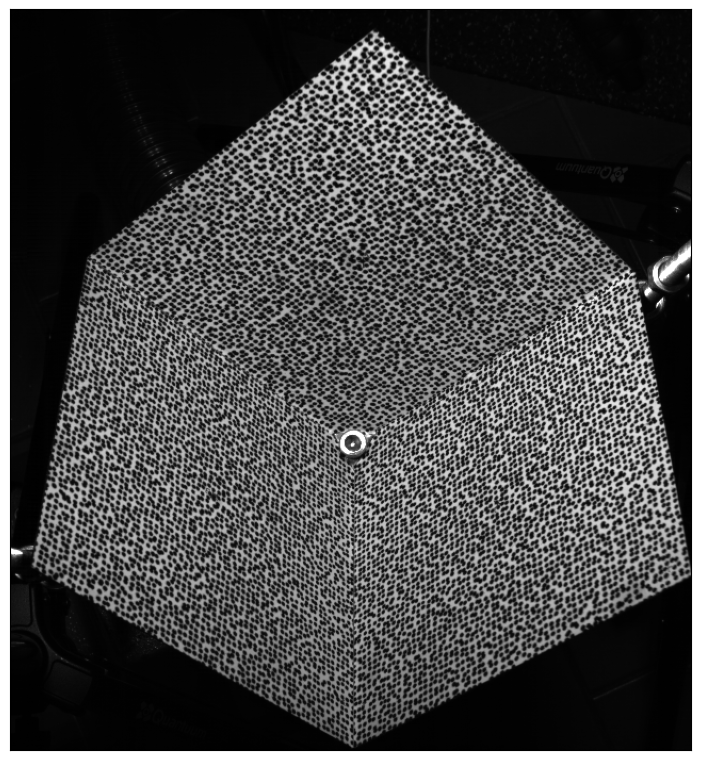

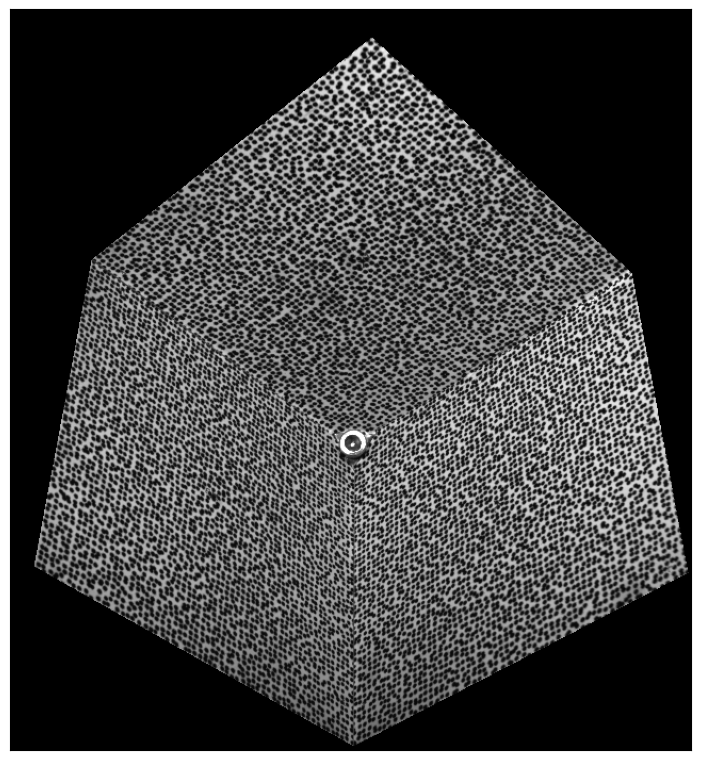

In [6]:
%matplotlib inline
reference_image = (0, 200)
mean_image      = np.mean(DIC_structure.video.mraw[reference_image[0]:reference_image[1]], axis=0)
# Show the mean image
fig, ax = DIC_structure.plot_frame(sequential_image_n = reference_image) 

# Mask the mean image
mask_image = path.contains_points(np.array([(i,j) for i in range(mean_image.shape[0]) for j in range(mean_image.shape[1])]))
mask_image = mask_image.reshape(mean_image.shape)
mean_image_masked = np.copy(mean_image)
mean_image_masked[~mask_image] = 0

# Show the masked image
fig, ax = DIC_structure.plot_frame(sequential_image_n = mean_image_masked)

### Let's pick some corner like points

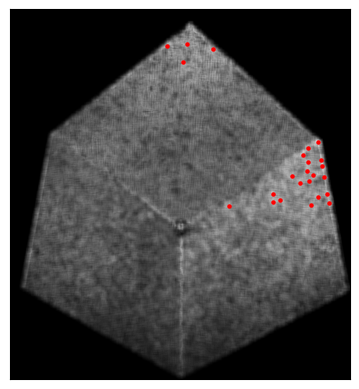

(<Figure size 640x480 with 1 Axes>, <Axes: >)

In [9]:
roi_size = (11,11) # Region of interest size (size of the correlation window)
DIC_structure.set_image(mean_image_masked)
DIC_structure.set_filter_method(filter_method = 'eig0', roi_size = roi_size)
score_image = DIC_structure.apply_filter()

n_tracking_points = 24    # Number of points to track
minimum_score = 100         # Absolute minimum score for a point to be considered

# points = DIC_structure.pick_max_filter(score_image = filtered_image, min_distance = roi_size[0], absolute_treshold = None, threshold_percentage = 0, top_n_points = n_tracking_points)
# points = DIC_structure.pick_ANMS(score_image = filtered_image, n_points=n_tracking_points, c_robust=0.05)
points = DIC_structure.pick_max_loop(score_image = score_image, min_distance = roi_size, n_points = n_tracking_points, minimum_score= minimum_score)

DIC_structure.plot_score_image(maxima=True)

### Let's track the points

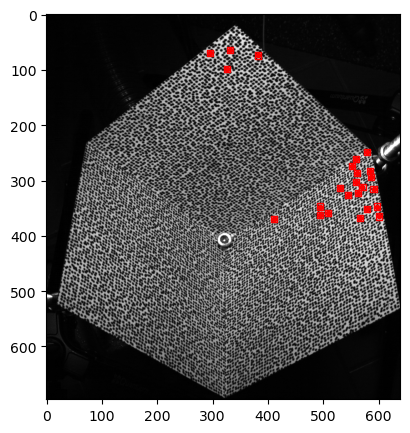

c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\pyidi\methods\_lucas_kanade.py:559: ResourceWarning: unclosed file <_io.BufferedReader name='D:/thijsmas/HSC - Ladisk/transfer_104353_files_9c630a94\\temp_file\\settings.pkl'>
  settings_old = pickle.load(open(self.settings_filename, 'rb'))
c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\pyidi\methods\_lucas_kanade.py:571: ResourceWarning: unclosed file <_io.BufferedReader name='D:/thijsmas/HSC - Ladisk/transfer_104353_files_9c630a94\\temp_file\\points.pkl'>
  points = pickle.load(open(os.path.join(self.temp_dir, 'points.pkl'), 'rb'))


--- Starting new analysis ---
 
Computation start: 2024-04-03 15:04:28.884795


c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


VBox()

Computation duration: 00:02:45.49


array([[[ 0.        ,  0.        ],
        [ 0.06203392, -0.09140583],
        [ 0.05875018, -0.09107601],
        ...,
        [-0.00798142, -0.0157087 ],
        [-0.00053712, -0.01461747],
        [-0.00406861, -0.01070501]],

       [[ 0.        ,  0.        ],
        [ 0.01944745, -0.1562945 ],
        [ 0.01874111, -0.15819077],
        ...,
        [-0.06935808, -0.09922748],
        [-0.06473423, -0.10822186],
        [-0.06593172, -0.10714594]],

       [[ 0.        ,  0.        ],
        [-0.05112004, -0.25993827],
        [-0.04817932, -0.2643895 ],
        ...,
        [-0.15872721, -0.21944464],
        [-0.14886006, -0.21031682],
        [-0.14937754, -0.21598745]],

       ...,

       [[ 0.        ,  0.        ],
        [ 0.02346701, -0.14565031],
        [ 0.01287071, -0.14028619],
        ...,
        [-0.10101825, -0.13258482],
        [-0.10341265, -0.1361912 ],
        [-0.09558055, -0.13728463]],

       [[ 0.        ,  0.        ],
        [ 0.03303776, -0.11

In [10]:
DIC_structure.set_method('lk') # Set the method to Lucas-Kanade
DIC_structure.method.configure(roi_size = roi_size, reference_image = mean_image, resume_analysis=False) #, mraw_range=(1, 1000)
DIC_structure.set_points(points)
DIC_structure.show_points()
d = DIC_structure.get_displacements(processes = 24)


### Open old test results
Test settings, point locations, and retrieved displacements are automatically saved in the root folder of the video. A testnumber is automatically generated (sequentially)

In [22]:
test_number = 1
previous_files_root = os.path.join(file_root, file_name.split('.')[0] + '_pyidi_analysis', f'analysis_{str(test_number).zfill(3)}')
with open(os.path.join(previous_files_root, 'points.pkl'), 'rb') as f:
    points = pk.load(f)
with open(os.path.join(previous_files_root, 'results.pkl'), 'rb') as f:
    d = pk.load(f)
with open(os.path.join(previous_files_root, 'settings.txt'), 'rb') as f:
    settings = f.read().decode('utf-8')
pprint.pprint(settings)

('{\r\n'
 '  "cih_file": "D:/thijsmas/HSC - '
 'Ladisk/transfer_104353_files_9c630a94\\\\1mm_meritev_1_nasproti_1_3g_RMS_1s.cih",\r\n'
 '  "createdate": "2024 04 03    15:07:14",\r\n'
 '  "info": {\r\n'
 '    "AnalogBoard Channel Num": 0,\r\n'
 '    "Auto Exposure": "Off",\r\n'
 '    "Camera ID": 11,\r\n'
 '    "Camera Number": 0,\r\n'
 '    "Camera Type": "FASTCAM SA-Z type 2100K-M-64GB",\r\n'
 '    "Color Bit": 16,\r\n'
 '    "Color Type": "Mono",\r\n'
 '    "Comment Text": "",\r\n'
 '    "Correct Trigger Frame": 0,\r\n'
 '    "Current Partition": 1,\r\n'
 '    "Current Time Decimal Divide": 0,\r\n'
 '    "Current Time Decimal Place": 0,\r\n'
 '    "Current Time Max Display Unit": 0,\r\n'
 '    "DS Shutter": "Value 0",\r\n'
 '    "Date": "2018/2/22",\r\n'
 '    "Date Record": "Unknown",\r\n'
 '    "Device Last Error": "-1:0xffffffff",\r\n'
 '    "Digits Of File Number": 6,\r\n'
 '    "Edge Enhance": 0,\r\n'
 '    "EffectiveBit Depth": 12,\r\n'
 '    "EffectiveBit Side": "Higher",\r\n

### Let's look at the results

In [27]:
%matplotlib qt
td     = d +  points.reshape(len(points),1,2)
ani = DIC_structure.play_video(frame_range=range(1, DIC_structure.video.N), interval = 30, show_saturation= False, bit_depth = 'auto', ij_counter = (0.3, 0.3), points=td)

In [36]:
t_vec = np.arange(0, d.shape[1]) * DIC_structure.info['Record Rate(fps)']
fig, ax = plt.subplots(2,1)
for d_p in d:
    ax[0].plot(t_vec, d_p[:,0],'k', label = 'displacement - i', lw=0.2)
    ax[1].plot(t_vec, d_p[:,1],'k', label = 'displacement - j', lw=0.2)
ax[1].set_xlabel('Time [s]')
ax[0].set_ylabel('Displacement [px]')
ax[1].set_ylabel('Displacement [px]')

Text(0, 0.5, 'Displacement [px]')